# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 250     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1914.452392578125
iteration 0 loss 68.45426940917969


iteration 5000 loss 0.15762653946876526


iteration 10000 loss 0.0678865984082222


iteration 15000 loss 0.04221108928322792


iteration 20000 loss 0.0290360189974308


iteration 25000 loss 0.020848458632826805


iteration 30000 loss 0.016045134514570236


iteration 35000 loss 0.013423922471702099


iteration 40000 loss 0.010881481692194939


iteration 45000 loss 0.009496613405644894


iteration 50000 loss 0.008626824244856834


iteration 55000 loss 0.007491647265851498


iteration 60000 loss 0.006970833521336317


iteration 65000 loss 0.0063771833665668964


iteration 70000 loss 0.005973003804683685


iteration 75000 loss 0.005262898746877909


iteration 80000 loss 0.004812392871826887


iteration 85000 loss 0.00470640417188406


iteration 90000 loss 0.00445033423602581


iteration 95000 loss 0.004265118855983019


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.003872143104672432


iteration 105000 loss 0.003360342001542449


iteration 110000 loss 0.003009613836184144


iteration 115000 loss 0.002777645830065012


iteration 120000 loss 0.00261037633754313


iteration 125000 loss 0.0024394874926656485


iteration 130000 loss 0.002302042441442609


iteration 135000 loss 0.002182702301070094


iteration 140000 loss 0.0020742197521030903


iteration 145000 loss 0.0030375628266483545


iteration 150000 loss 0.0018875267123803496


iteration 155000 loss 0.001805008272640407


iteration 160000 loss 0.0017312610289081931


iteration 165000 loss 0.0016594926128163934


iteration 170000 loss 0.0015940612647682428


iteration 175000 loss 0.0015345565043389797


iteration 180000 loss 0.0014775003073737025


iteration 185000 loss 0.0014236579881981015


iteration 190000 loss 0.0013880874030292034


iteration 195000 loss 0.0013280091807246208


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.0012857174733653665


iteration 205000 loss 0.00126643234398216


iteration 210000 loss 0.0012288328725844622


iteration 215000 loss 0.0011918257223442197


iteration 220000 loss 0.0011568072950467467


iteration 225000 loss 0.0011231092503294349


iteration 230000 loss 0.001304727396927774


iteration 235000 loss 0.0010721863945946097


iteration 240000 loss 0.001034017652273178


iteration 245000 loss 0.0010069768177345395


iteration 250000 loss 0.0009803102584555745


iteration 255000 loss 0.0009549902752041817


iteration 260000 loss 0.0009304298437200487


iteration 265000 loss 0.00090683379676193


iteration 270000 loss 0.0008851266466081142


iteration 275000 loss 0.0008634084369987249


iteration 280000 loss 0.0008427494904026389


iteration 285000 loss 0.0008227851940318942


iteration 290000 loss 0.000803787203039974


iteration 295000 loss 0.0007859109318815172


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0007686547469347715


iteration 305000 loss 0.00076267373515293


iteration 310000 loss 0.0007424529176205397


iteration 315000 loss 0.0007227370515465736


iteration 320000 loss 0.0007042995421215892


iteration 325000 loss 0.0006861657602712512


iteration 330000 loss 0.0006693342002108693


iteration 335000 loss 0.0006530387909151614


iteration 340000 loss 0.0006373133510351181


iteration 345000 loss 0.0006219680653885007


iteration 350000 loss 0.0006067943759262562


iteration 355000 loss 0.0005927253514528275


iteration 360000 loss 0.000579137762542814


iteration 365000 loss 0.0005657085566781461


iteration 370000 loss 0.0005532068898901343


iteration 375000 loss 0.0005413758917711675


iteration 380000 loss 0.0005296160816214979


iteration 385000 loss 0.000518374377861619


iteration 390000 loss 0.0005072786007076502


iteration 395000 loss 0.0004963662941008806


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0004857520980294794


iteration 405000 loss 0.00048117287224158645


iteration 410000 loss 0.00047121572424657643


iteration 415000 loss 0.0004615501675289124


iteration 420000 loss 0.0004521512018982321


iteration 425000 loss 0.00044300040462985635


iteration 430000 loss 0.000434076355304569


iteration 435000 loss 0.00042537334957160056


iteration 440000 loss 0.000416887691244483


iteration 445000 loss 0.0004086264525540173


iteration 450000 loss 0.0004005558730568737


iteration 455000 loss 0.0003926733916159719


iteration 460000 loss 0.00038495229091495275


iteration 465000 loss 0.0003774068027269095


iteration 470000 loss 0.0003700315428432077


iteration 475000 loss 0.0003628171398304403


iteration 480000 loss 0.00035576571826823056


iteration 485000 loss 0.00034886173671111465


iteration 490000 loss 0.00034210950252600014


iteration 495000 loss 0.0003355092485435307


L2 loss -- Plot

loss 10.41572093963623


loss -99.94056701660156


loss -176.11795043945312


loss -238.77932739257812


loss -290.41015625


loss -333.111572265625


loss -368.47601318359375


loss -397.682861328125


loss -421.6719055175781


loss -441.2144775390625


loss -456.9374694824219


loss -469.36834716796875


loss -478.9805908203125


loss -486.2133483886719


loss -491.4768371582031


loss -495.1566162109375


loss -497.61163330078125


loss -499.1645202636719


loss -500.0885009765625


loss -500.59942626953125


loss -500.85614013671875


loss -500.96881103515625


loss -501.00946044921875


loss -501.0206298828125


loss -501.022705078125


loss -501.02294921875


loss -501.0229797363281


loss -501.02294921875


loss -501.0229797363281


loss -501.02301025390625


loss -501.02301025390625


loss -501.0229797363281


loss -501.0229797363281


loss -501.0229797363281


loss -501.0229797363281


loss -501.02301025390625


loss -501.02301025390625


loss -501.02301025390625


loss -501.0229797363281


loss -501.02301025390625


final mse:  3.8832098647745283e-10
max, min: 6.646191 -8.261623
loss 10.41572093963623


loss -102.14481353759766


loss -183.97268676757812


loss -254.41017150878906


loss -314.59735107421875


loss -365.6976318359375


loss -408.86114501953125


loss -445.1261291503906


loss -475.376708984375


loss -500.3436584472656


loss -520.646484375


loss -536.845458984375


loss -549.4698486328125


loss -559.0289306640625


loss -566.0176391601562


loss -570.9138793945312


loss -574.1676025390625


loss -576.1898193359375


loss -577.3423461914062


loss -577.9285888671875


loss -578.1849975585938


loss -578.2766723632812


loss -578.3016967773438


loss -578.3065185546875


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


loss -578.30712890625


final mse:  3.340231424786566e-10
max, min: 7.913336 -7.8231325


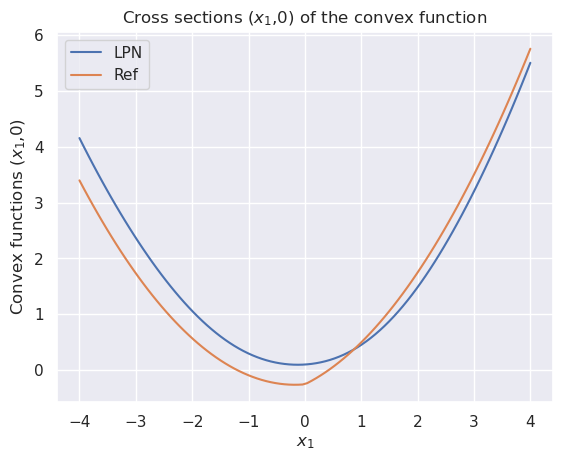

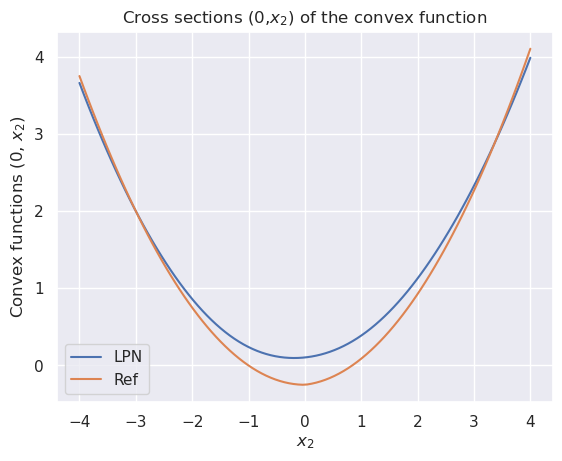

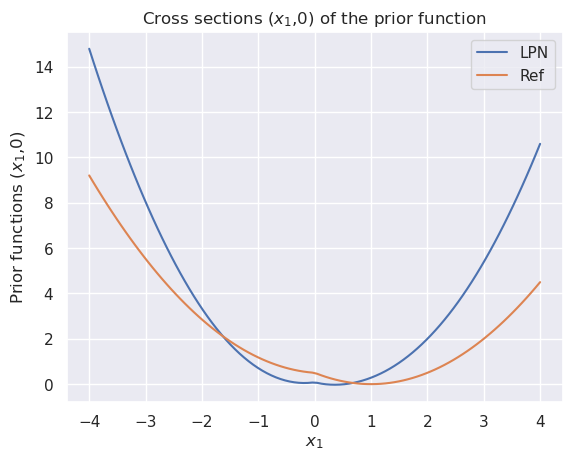

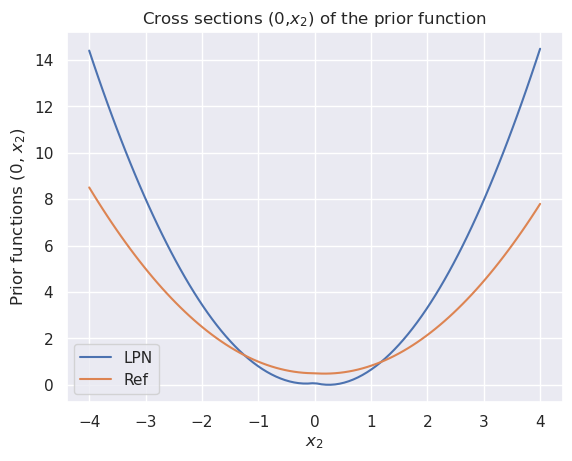

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1705.5003662109375
iteration 0 loss 488.56939697265625


iteration 5000 loss 5.611208438873291


iteration 10000 loss 0.2547945976257324


iteration 15000 loss 0.11700214445590973


iteration 20000 loss 0.07268290966749191


iteration 25000 loss 0.05517350509762764


iteration 30000 loss 0.04518500715494156


iteration 35000 loss 0.03800835832953453


iteration 40000 loss 0.032585520297288895


iteration 45000 loss 0.028594249859452248


iteration 50000 loss 0.025936657562851906


iteration 55000 loss 0.02332228049635887


iteration 60000 loss 0.021441156044602394


iteration 65000 loss 0.019665570929646492


iteration 70000 loss 0.018223540857434273


iteration 75000 loss 0.0169443991035223


iteration 80000 loss 0.01573852449655533


iteration 85000 loss 0.01473292801529169


iteration 90000 loss 0.013721227645874023


iteration 95000 loss 0.013003832660615444


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.012095941230654716


iteration 105000 loss 0.01153463777154684


iteration 110000 loss 0.010889329947531223


iteration 115000 loss 0.010273072868585587


iteration 120000 loss 0.009741625748574734


iteration 125000 loss 0.009261824190616608


iteration 130000 loss 0.008815200999379158


iteration 135000 loss 0.0084040192887187


iteration 140000 loss 0.008048675023019314


iteration 145000 loss 0.007700804155319929


iteration 150000 loss 0.007423643488436937


iteration 155000 loss 0.007088883779942989


iteration 160000 loss 0.00686069717630744


iteration 165000 loss 0.006614206358790398


iteration 170000 loss 0.006363309919834137


iteration 175000 loss 0.006152597721666098


iteration 180000 loss 0.005924344062805176


iteration 185000 loss 0.005733181722462177


iteration 190000 loss 0.00552655104547739


iteration 195000 loss 0.005370583850890398


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.005174964666366577


iteration 205000 loss 0.005049731116741896


iteration 210000 loss 0.004866121336817741


iteration 215000 loss 0.00468970462679863


iteration 220000 loss 0.004524223040789366


iteration 225000 loss 0.004378594923764467


iteration 230000 loss 0.004240366164594889


iteration 235000 loss 0.004102093167603016


iteration 240000 loss 0.003979758359491825


iteration 245000 loss 0.0038523669354617596


iteration 250000 loss 0.003744952380657196


iteration 255000 loss 0.003641432151198387


iteration 260000 loss 0.0035424246452748775


iteration 265000 loss 0.003447680501267314


iteration 270000 loss 0.0033549636136740446


iteration 275000 loss 0.003255232237279415


iteration 280000 loss 0.0031720753759145737


iteration 285000 loss 0.003093274775892496


iteration 290000 loss 0.003016453003510833


iteration 295000 loss 0.0029409872367978096


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.0028706130106002092


iteration 305000 loss 0.0028521972708404064


iteration 310000 loss 0.0028092546854168177


iteration 315000 loss 0.0027674122247844934


iteration 320000 loss 0.002727339742705226


iteration 325000 loss 0.0026886744890362024


iteration 330000 loss 0.0026511852629482746


iteration 335000 loss 0.0026147784665226936


iteration 340000 loss 0.002579346066340804


iteration 345000 loss 0.002544775605201721


iteration 350000 loss 0.0025110431015491486


iteration 355000 loss 0.002478097565472126


iteration 360000 loss 0.002445894293487072


iteration 365000 loss 0.002414340851828456


iteration 370000 loss 0.002383427694439888


iteration 375000 loss 0.0023531271144747734


iteration 380000 loss 0.0023234058171510696


iteration 385000 loss 0.002294249599799514


iteration 390000 loss 0.002265636110678315


iteration 395000 loss 0.002237548353150487


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.0022099469788372517


iteration 405000 loss 0.0022070202976465225


iteration 410000 loss 0.002203960670158267


iteration 415000 loss 0.0022009608801454306


iteration 420000 loss 0.002197991358116269


iteration 425000 loss 0.0021950595546513796


iteration 430000 loss 0.0021921489387750626


iteration 435000 loss 0.0021892625372856855


iteration 440000 loss 0.0021863984875380993


iteration 445000 loss 0.002183551201596856


iteration 450000 loss 0.002180721377953887


iteration 455000 loss 0.002177904359996319


iteration 460000 loss 0.0021751064341515303


iteration 465000 loss 0.002172323176637292


iteration 470000 loss 0.0021695538889616728


iteration 475000 loss 0.0021667983382940292


iteration 480000 loss 0.0021640548948198557


iteration 485000 loss 0.002161328913643956


iteration 490000 loss 0.0021586092188954353


iteration 495000 loss 0.0021559027954936028


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


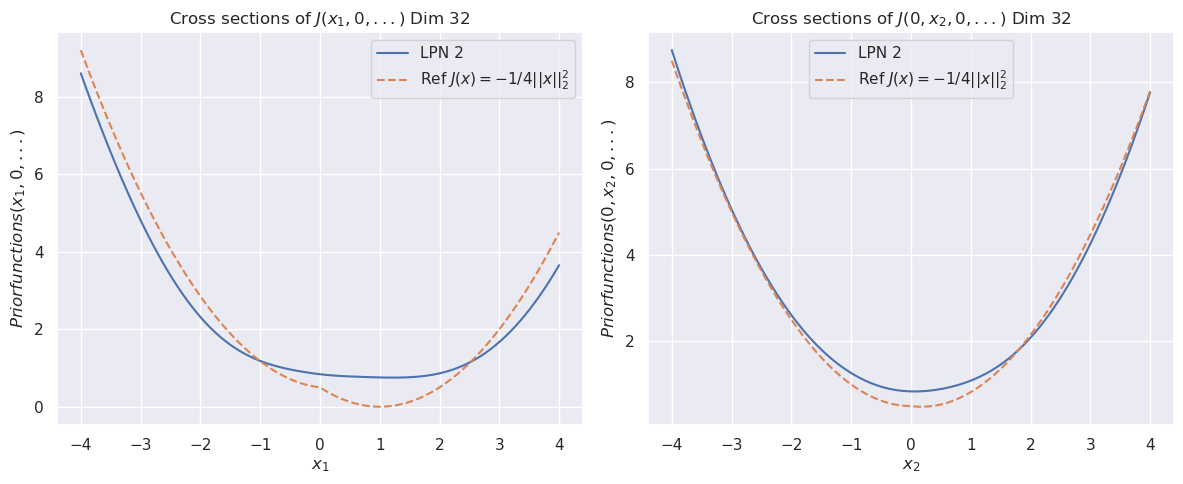

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)